Below I am trying to execute the load_image where the images are loaded and then each image is converted to grayscale using "L" method and then resized from actual image size to 100x100 in order to reduce the number of features and ease in training .

In [37]:
import numpy as np
from PIL import Image
import glob
import os
def load_image(dataset_dir, size=(200,200)):
    X1=[]   # list to store the image data
    y1=[]   # list to store the labels of the image dataset
    #there are two folders in my dataset "abnormal->1" adn "normal->0"
    classes={
        "normal" :0,
        "abnormal": 1
    }
    # entering into the each class inside the folder
    for class_name, class_label in classes.items():
        folder = os.path.join(dataset_dir,class_name)
        image_paths = glob.glob(folder+"/*.png")
        for path in image_paths:
            img = Image.open(path)
            # converting images to grayscale
            img = img.convert("L")  # using this method converting all the images to greyscale images
            #resizing all images
            img = img.resize(size)
            #converting all images to array
            arr = np.array(img, dtype=np.float32)/255.0
            #flattening all the images
            arr = arr.flatten()
            X1.append(arr)
            y1.append(class_label)
    X = np.array(X1)
    Y = np.array(y1)
    return X,Y


Calling the load_image function and storing the data into X variable and labels of true values into Y variable
For experiment no 1 : using X and Y where image size is 100x100
For experiment no 2 : using X1 and Y1 where image size is 70x70

Experiment no 1: X and image size: 100x100

In [38]:
X,Y = load_image("C:/Users/HP/Downloads/dataset-fro-programming&mathsforAI/spectrogramprocessedata/dataset")

Experiment no 2: X1 and Y1 and image size: 70x70

In [29]:
X.shape, Y.shape # Experiment no 1
X1.shape, Y1.shape # Experiment no 2

((5235, 4900), (5235,))

In [28]:
X1,Y1 = load_image("C:/Users/HP/Downloads/dataset-fro-programming&mathsforAI/spectrogramprocessedata/dataset", size=(70,70))

Splittign the dataset intro trainin and tetsing data in the ratio 80% trainig data and 20% testing data 

In [39]:
def train_test_split(X, y, test_ratio=0.2):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    split = int(N * (1 - test_ratio))

    train_idx = idx[:split]
    test_idx  = idx[split:]

    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]


In [40]:
X_train, y_train, X_test, y_test = train_test_split(X, Y, test_ratio=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(4188, 40000) (4188,)
(1047, 40000) (1047,)


Experiment no 2 splitting the dataset

In [42]:
X_train, y_train, X_test, y_test = train_test_split(X, Y, test_ratio=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(4188, 40000) (4188,)
(1047, 40000) (1047,)


In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Suppose majority = class 1, minority = class 0
smote = SMOTE(sampling_strategy=0.7, random_state=42)  # minority will be 70% of majority
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Zeros:", np.sum(y_train_balanced == 0))
print("Ones :", np.sum(y_train_balanced == 1))


# Building the layers of the neural Network using Numpy

In [12]:
class Linear:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim)*0.01
        self.b = np.zeros((out_dim,))

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad_out, l2=0.0):
        self.dW = self.x.T @ grad_out + l2*self.W
        self.db = np.sum(grad_out, axis=0)
        return grad_out @ self.W.T


In [13]:
class ReLU:
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, grad_out):
        return grad_out * self.mask

In [14]:
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(pred, y):
    N = y.shape[0]
    p = pred[range(N), y]
    return -np.mean(np.log(p + 1e-12))

def softmax_backward(pred, y):
    grad = pred.copy()
    grad[np.arange(len(y)), y] -= 1
    return grad / len(y)


In [15]:
class Dropout:
    def __init__(self, p=0.2):
        self.p = p
        self.mask = None
        self.training = True

    def forward(self, x):
        if self.training:
            keep = 1 - self.p
            self.mask = (np.random.rand(*x.shape) < keep) / keep
            return x * self.mask
        else:
            return x  # no scaling needed (inverted dropout)

    def backward(self, grad_out):
        if self.training:
            return grad_out * self.mask
        else:
            return grad_out


In [16]:
class SimpleNN:
    def __init__(self, input_dim, hidden_dim=128, output_dim=2):
        self.l1 = Linear(input_dim, hidden_dim)
        self.a1 = ReLU()
        self.l2 = Linear(hidden_dim, output_dim)

    def forward(self, x):
        z1 = self.l1.forward(x)
        a1 = self.a1.forward(z1)
        z2 = self.l2.forward(a1)
        return z2

    def backward(self, grad, l2=0.0):
        grad = self.l2.backward(grad, l2=l2)
        grad = self.a1.backward(grad)
        grad = self.l1.backward(grad, l2=l2)
        return grad

    def update(self, lr):
        # Update parameters of BOTH Linear layers
        for layer in [self.l1, self.l2]:
            layer.W -= lr * layer.dW
            layer.b -= lr * layer.db

    def predict(self, X):
        logits = self.forward(X)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)


In [17]:
def confusion_matrix(y_true, y_pred, num_classes=2):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes=['normal', 'abnormal']):
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # write numbers inside boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [18]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def plot_metrics(history):
    epochs = range(1, len(history["loss"])+1)
    
    plt.figure(figsize=(16,5))
    
    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, history["loss"], label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.grid(True)
    
    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["test_acc"], label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.legend()
    plt.grid(True)
    
    # Precision / Recall / F1
    plt.subplot(1,3,3)
    plt.plot(epochs, history["precision"], label="Precision")
    plt.plot(epochs, history["recall"], label="Recall")
    plt.plot(epochs, history["f1"], label="F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Precision / Recall / F1 vs Epoch")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def train(model, X_train, y_train, X_test, y_test, lr=0.01, epochs=20, l2=0.0):

    # Storage dictionary for plots
    history = {
        "loss": [],
        "train_acc": [],
        "test_acc": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for epoch in range(epochs):

        # ----- Forward -----
        logits = model.forward(X_train)
        probs = softmax(logits)

        # ----- Loss -----
        loss = cross_entropy(probs, y_train)
        loss += (l2/2) * (np.sum(model.l1.W**2) + np.sum(model.l2.W**2))

        # ----- Backward -----
        grad = softmax_backward(probs, y_train)
        model.backward(grad, l2=l2)

        # ----- Update -----
        model.update(lr)

        # ----- Train Accuracy -----
        train_preds = model.predict(X_train)
        train_acc = accuracy(y_train, train_preds)

        # ----- Test Accuracy -----
        test_preds = model.predict(X_test)
        test_acc = accuracy(y_test, test_preds)

        # ---- Classification Metrics (Test Set) ----
        prec = precision_score(y_test, test_preds, average='macro')
        rec  = recall_score(y_test, test_preds, average='macro')
        f1   = f1_score(y_test, test_preds, average='macro')

        # Save to history for plotting
        history["loss"].append(loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        history["precision"].append(prec)
        history["recall"].append(rec)
        history["f1"].append(f1)

        print(f"Epoch {epoch+1}/{epochs}  Loss={loss:.4f}  "
              f"TrainAcc={train_acc:.4f}  TestAcc={test_acc:.4f}  "
              f"Prec={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

    # ===== FINAL EVALUATION =====
    final_train_preds = model.predict(X_train)
    final_test_preds = model.predict(X_test)

    final_train_acc = accuracy(y_train, final_train_preds)
    final_test_acc  = accuracy(y_test, final_test_preds)

    print("\n=== Final Accuracy ===")
    print(f"Train Accuracy : {final_train_acc:.4f}")
    print(f"Test Accuracy  : {final_test_acc:.4f}")

    # FIX: final_preds → final_test_preds
    cm = confusion_matrix(y_test, final_test_preds)
    print("\nConfusion Matrix:\n", cm)

    plot_confusion_matrix(cm)

    return history


In [20]:
print(X_test.shape, y_test.shape)  # should be (num_samples, num_features), (num_samples,)


(1047, 10000) (1047,)


In [43]:
model = SimpleNN(input_dim=X_train.shape[1], hidden_dim=400, output_dim=2)

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/90  Loss=0.6965  TrainAcc=0.5074  TestAcc=0.5119  Prec=0.2560  Recall=0.5000  F1=0.3386
Epoch 2/90  Loss=0.6935  TrainAcc=0.5134  TestAcc=0.5205  Prec=0.5859  Recall=0.5093  F1=0.3737
Epoch 3/90  Loss=0.6924  TrainAcc=0.5084  TestAcc=0.5158  Prec=0.5167  Recall=0.5064  F1=0.4208
Epoch 4/90  Loss=0.6919  TrainAcc=0.5119  TestAcc=0.5014  Prec=0.4945  Recall=0.4958  F1=0.4684
Epoch 5/90  Loss=0.6916  TrainAcc=0.5260  TestAcc=0.5177  Prec=0.5159  Recall=0.5152  F1=0.5110
Epoch 6/90  Loss=0.6913  TrainAcc=0.5425  TestAcc=0.5339  Prec=0.5332  Recall=0.5330  F1=0.5327
Epoch 7/90  Loss=0.6911  TrainAcc=0.5454  TestAcc=0.5501  Prec=0.5503  Recall=0.5503  F1=0.5501
Epoch 8/90  Loss=0.6908  TrainAcc=0.5516  TestAcc=0.5587  Prec=0.5595  Recall=0.5594  F1=0.5586
Epoch 9/90  Loss=0.6907  TrainAcc=0.5573  TestAcc=0.5635  Prec=0.5651  Recall=0.5646  F1=0.5631
Epoch 10/90  Loss=0.6905  TrainAcc=0.5649  TestAcc=0.5654  Prec=0.5675  Recall=0.5668  F1=0.5647
Epoch 11/90  Loss=0.6904  TrainAcc=0.56

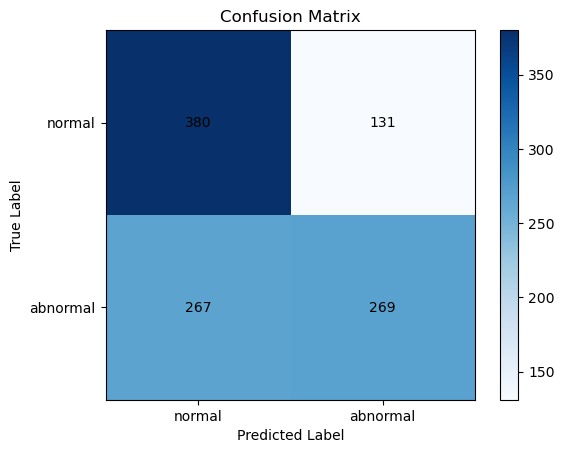

In [44]:
history = train(
    model, 
    X_train, y_train, 
    X_test, y_test,
    lr=0.001,       # learning rate
    epochs=90,      # number of epochs
    l2=0.00      # L2 regularization strength

)



In [34]:
X_train.shape, y_train.shape
X_test.shape, y_train.shape

((1047, 4900), (4188,))

In case of Experiment  no 1 where the image size was 100x100 the accuracy was lower around 49% testing accuracy. The plots obtained clearly indicates that the model wasnt performing that great 
1. loss vs epoch here in this plot its steep plot hence leading to the unseen behavour of the model beyond 90 epochs
2. There is quite a hude difference between trainign and testing accuracy vs epoch curve 
3. There is a huge variation in the precision curve, the F1 curve is quite stable indicating the model struggled with learnign and same is the case with recall

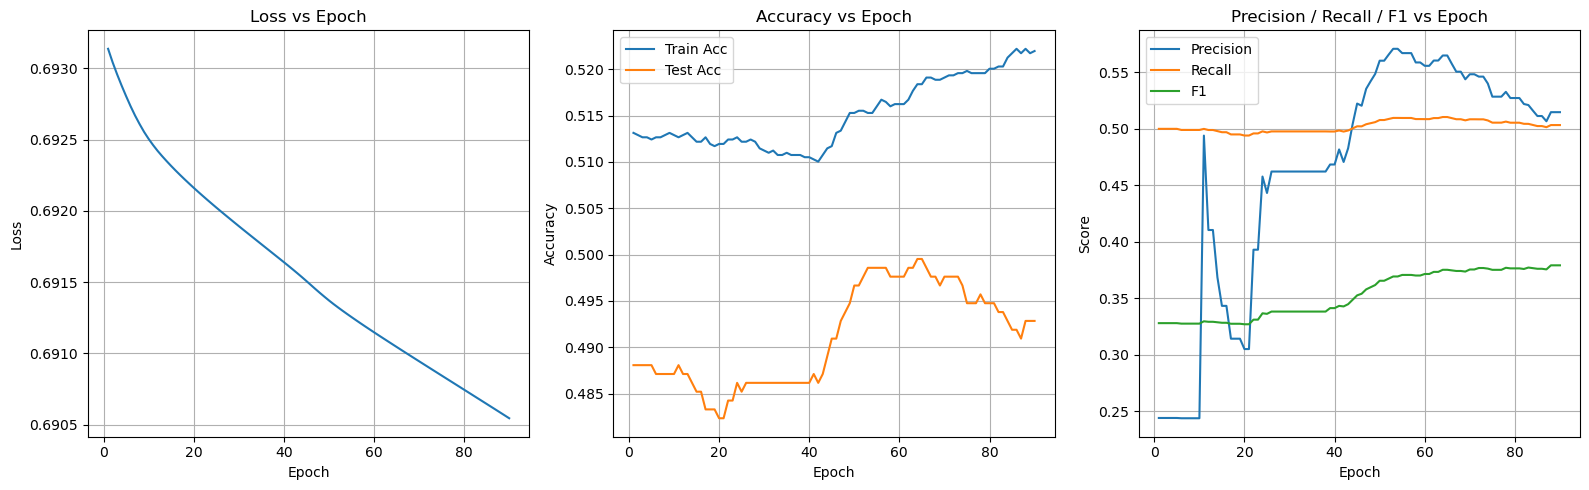

In [ ]:
plot_metrics(history)


In case of experiment no 2 the accuracy is higher than that of the previous case as the resolution of the image size is around 2 times more than that initial size (100x100) hence more number of features are learnt in this case comapred to that of the previous case.To check the behaviour of the model more we will now change the optimizer from gradient descent to "Adam Optimizer" in order to check the results keeping the image size same as that of (200x200) 

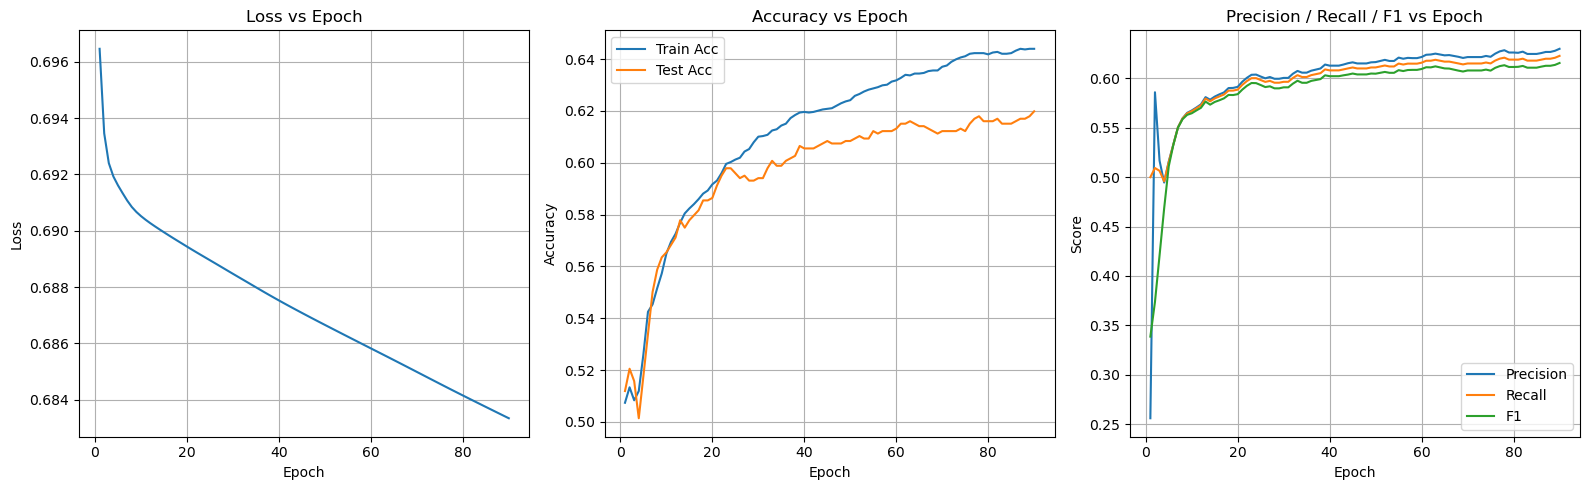

In [ ]:
plot_metrics(history)
#new file 

Below is the code which was implemented in order to apply data augmentation technique on the minor class (Abnormal heart beat sounds)

In [ ]:
import os
from PIL import Image
from torchvision import transforms
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])
import os
from PIL import Image
from torchvision import transforms

# Define augmentation pipeline (no rotation)
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),  # added vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0))  # adjust size as needed
])

input_dir = 'spectrogramprocessedata/abnormal'       # folder with original abnormal images
output_dir = 'spectrogramprocessedata/aug1_abnormal'  # folder to save augmented images
os.makedirs(output_dir, exist_ok=True)

num_augmentations = 3  # how many augmented copies per original image

for filename in os.listdir(input_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path).convert('RGB')
        
        # Save the original image to the augmented folder as well
        base_name, ext = os.path.splitext(filename)
        img.save(os.path.join(output_dir, f"{base_name}_orig{ext}"))
        
        # Generate augmented copies
        for i in range(num_augmentations):
            aug_img = augment(img)
            aug_img.save(os.path.join(output_dir, f"{base_name}_aug{i}{ext}"))
